In [1]:
import zipfile
import numpy as np
from IPython.display import Image

In [2]:
local_zip = './drive/MyDrive/IMAGES.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./images')
zip_ref.close()

In [3]:
import os
train_real_dir = os.path.join('./images/train/REAL')
train_fake_dir = os.path.join('./images/train/REAL')

In [4]:
train_real_names = os.listdir(train_real_dir)
train_fake_names = os.listdir(train_fake_dir)
print(train_real_names[:10])

['0232 (4).jpg', '4753 (10).jpg', '4190 (8).jpg', '0222 (9).jpg', '2075 (2).jpg', '4372 (4).jpg', '3551 (8).jpg', '4112 (10).jpg', '4198 (4).jpg', '3635 (3).jpg']


In [5]:
print('total training horse images:', len(os.listdir(train_real_dir)))
print('total training human images:', len(os.listdir(train_fake_dir)))

total training horse images: 50000
total training human images: 50000


In [6]:
import tensorflow as tf

In [7]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow_from_directory(
        './images/train',
        target_size=(32, 32),
        batch_size=500,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 100000 images belonging to 2 classes.


In [9]:
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (32, 32, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (32, 32, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
     metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                              

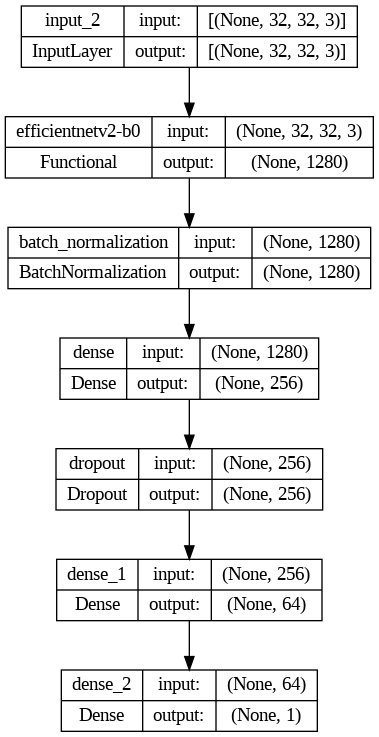

In [10]:
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [11]:
EfficientNet_model.load_weights('./drive/MyDrive/EfficientNetmodel_weights2.h5') #loading the trained weights

In [ ]:
EfficientNet_model_history = EfficientNet_model.fit(train_generator, steps_per_epoch = 200,epochs = 5, verbose = 1) #training the model

Epoch 1/5
200/200 [==============================] - 47s 234ms/step - loss: 0.0446 - accuracy: 0.9904 - precision: 0.9909 - recall: 0.9899
Epoch 2/5
200/200 [==============================] - 47s 233ms/step - loss: 0.0359 - accuracy: 0.9934 - precision: 0.9935 - recall: 0.9933
Epoch 3/5
200/200 [==============================] - 47s 235ms/step - loss: 0.0308 - accuracy: 0.9948 - precision: 0.9949 - recall: 0.9946
Epoch 4/5
200/200 [==============================] - 47s 234ms/step - loss: 0.0248 - accuracy: 0.9963 - precision: 0.9964 - recall: 0.9963
Epoch 5/5
200/200 [==============================] - 48s 237ms/step - loss: 0.0200 - accuracy: 0.9977 - precision: 0.9976 - recall: 0.9978


In [12]:
validation_datagen = ImageDataGenerator(rescale=1.0)
validation_generator = validation_datagen.flow_from_directory(
        './images/test',  # This is the source directory for validation images
        target_size=(32, 32),
        batch_size=2000,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')

Found 20000 images belonging to 2 classes.


In [13]:
EfficientNet_model.evaluate(validation_generator)

10/10 [==============================] - 41s 3s/step - loss: 0.1141 - accuracy: 0.9724 - precision: 0.9706 - recall: 0.9743


[0.11407109349966049,
 0.9724000096321106,
 0.9706116914749146,
 0.9743000268936157]

In [ ]:
EfficientNet_model.save_weights('EfficientNetmodel_weights2.h5') #saving the weights

In [ ]:
from google.colab import files
files.download('EfficientNetmodel_weights2.h5') #downloading the trained weights from colab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(32, 32))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = EfficientNet_model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a real image")
  else:
    print(fn + " is a fake image")


KeyboardInterrupt: 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
